In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import datetime
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.layers import Dense,Dropout,Conv3D,Input,MaxPool3D,Flatten,Activation,AvgPool3D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import cv2
from keras.utils import np_utils

In [ ]:
actions = ["brush_hair","eat","hit","sit","stand"]
labels_map = {}
for label,action in enumerate(actions):
  labels_map[action] = label
labels_map

{'brush_hair': 0, 'eat': 1, 'hit': 2, 'sit': 3, 'stand': 4}

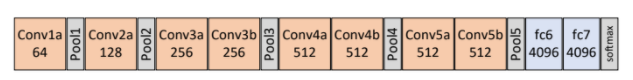

In [ ]:
def c3d_model():
    input_shape = (112,112,16,3)
    weight_decay = 0.003
    nb_classes = 5

    inputs = Input(input_shape)
    x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(inputs)
    x = MaxPool3D((2,2,1),strides=(2,2,1),padding='same')(x)

    x = Conv3D(128,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    x = Conv3D(128,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    x = Conv3D(256,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    x = Conv3D(256, (3, 3, 3), strides=(1, 1, 1), padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(2048,activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Dense(2048,activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Dense(nb_classes,kernel_regularizer=l2(weight_decay))(x)
    x = Activation('softmax')(x)

    model = Model(inputs, x)
    return model

In [ ]:
def c3d_model1():
  input_shape = (112,112,16,3)
  learning_rate = 0.005
  out_class = 5
  inputs = Input(input_shape)
  x = Conv3D(filters=64,kernel_size=(3,3,3),strides=(1,1,1),padding='same',activation='relu',kernel_regularizer=l2(learning_rate))(inputs)
  x = AvgPool3D(pool_size=(2,2,1),strides=(2,2,1),padding="same")(x)
  x = Conv3D(filters=64,kernel_size=(3,3,3),strides=(1,1,1),padding="same",activation="relu",kernel_regularizer=l2(learning_rate))(x)
  x = AvgPool3D(pool_size=(2,2,2),strides=(2,2,2),padding="same")(x)
  x = Conv3D(filters=128,kernel_size=(3,3,3),strides=(1,1,1),padding="same",activation="relu",kernel_regularizer=l2(learning_rate))(x)
  x = Conv3D(filters=128,kernel_size=(3,3,3),strides=(1,1,1),padding="same",activation="relu",kernel_regularizer=l2(learning_rate))(x)
  x = AvgPool3D(pool_size=(2,2,2),strides=(2,2,2),padding="same")(x)
  x = Conv3D(filters=256,kernel_size=(3,3,3),strides=(1,1,1),padding="same",activation="relu",kernel_regularizer=l2(learning_rate))(x)
  x = Conv3D(filters=256,kernel_size=(3,3,3),strides=(1,1,1),padding="same",activation="relu",kernel_regularizer=l2(learning_rate))(x)
  x = AvgPool3D(pool_size=(2,2,2),strides=(2,2,2),padding="same")(x)
  x = Flatten()(x)
  x = Dense(2048,activation='relu',kernel_regularizer=l2(learning_rate))(x)
  x = Dropout(0.5)(x)
  x = Dense(2048,activation='relu',kernel_regularizer=l2(learning_rate))(x)
  x = Dropout(0.5)(x)
  x = Dense(out_class,kernel_regularizer=l2(learning_rate))(x)
  x = Activation('softmax')(x)
  model = Model(inputs, x)
  return model

In [ ]:
def process_batch(lines,img_path,train=True):
  num = len(lines)
  batch = np.zeros((num,16,112,112,3),dtype='float32')
  labels = np.zeros(num,dtype='int')
  for i in range(len(lines)):
    ls = lines[i].split(" ")
    path,label,symbol = ls[0],int(ls[-1]),int(ls[1]) - 1
    imgs = os.listdir(img_path + path)
    imgs.sort(key = str.lower)
    #Resize imgs,cvtColor, random select 16 frames 
    if train:
      crop_x = random.randint(0, 15)
      crop_y = random.randint(0, 58)
      is_flip = random.randint(0, 1)
      for i in range(16):
        img = imgs[symbol+j]
        image = cv2.imread(img_path + path + '/' + img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (171, 128))
        if is_flip == 1:
          image = cv2.flip(image, 1)
          batch[i][j][:][:][:] = image[crop_x:crop_x + 112, crop_y:crop_y + 112, :]
          labels[i] = label
    else:
      for j in range(16):
        img = imgs[symbol + j]
        image = cv2.imread(img_path + path + '/' + img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (171, 128))
        batch[i][j][:][:][:] = image[8:120, 30:142, :]
        labels[i] = label
  return batch,labels

In [ ]:
def preprocess(inputs):
    inputs[..., 0] -= 99.9
    inputs[..., 1] -= 92.1
    inputs[..., 2] -= 82.6
    inputs[..., 0] /= 65.8
    inputs[..., 1] /= 62.3
    inputs[..., 2] /= 60.3
    return inputs

In [ ]:
def generator_train_batch(train_txt,batch_size,num_classes,img_path):
  fh = open(train_txt,"r")
  lines = fh.readlines()
  num = len(lines)
  while True:
    new_line = []
    index = [i for i in range(num)]
    np.random.shuffle(index)
    for i in range(num):
      new_line.append(lines[index[i]])
    for i in range(int(num/batch_size)):
      #a -> b : 0 -> 16
      a = i * batch_size
      b = (i+1) * batch_size
      x_train,y_label = process_batch(new_line[a:b],img_path,train = False)
      x = preprocess(x_train)
      #swap location x
      x = np.transpose(x,(0,2,3,1,4))
      y = np_utils.to_categorical(np.array(y_label),num_classes)
      yield x,y    

In [ ]:
def generator_val_batch(val_txt,batch_size,num_classes,img_path):
  fh = open(val_txt,"r")
  lines = fh.readlines()
  num = len(lines)
  while True:
    new_line = []
    index = [i for i in range(num)]
    np.random.shuffle(index)
    for i in range(num):
      new_line.append(lines[index[i]])
    for i in range(int(num/batch_size)):
      #a -> b : 0 -> 16
      a = i * batch_size
      b = (i+1) * batch_size
      x_train,y_label = process_batch(new_line[a:b],img_path,train = False)
      x = preprocess(x_train)
      #swap location x
      x = np.transpose(x,(0,2,3,1,4))
      y = np_utils.to_categorical(np.array(y_label),num_classes)
      yield x,y    

In [ ]:
%load_ext tensorboard

In [ ]:
def main():
  img_path = "/content/drive/MyDrive/CDIO4_ObjectTracking_ActionRecognition/frames_hmdb51/"
  train_file = "/content/drive/MyDrive/CDIO4_ObjectTracking_ActionRecognition/train_list.txt"
  test_file = "/content/drive/MyDrive/CDIO4_ObjectTracking_ActionRecognition/test_list.txt"
  f1 = open(train_file,"r")
  f2 = open(test_file,"r")
  lines = f1.readlines()
  f1.close()
  train_samples = len(lines)
  lines = f2.readlines()
  f2.close()
  val_samples = len(lines)

  num_classes = 5
  batch_size = 16
  epochs = 16
  model = c3d_model()
  model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
  model.summary()
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  model.fit_generator(generator_train_batch(train_file,batch_size,num_classes,img_path),steps_per_epoch = train_samples // batch_size
                      ,epochs=epochs,callbacks=[tensorboard_callback], validation_data=generator_val_batch(test_file,batch_size,num_classes,img_path),
                      validation_steps=val_samples // batch_size,verbose=1)
  model.save("c3d_action.h5")
  model.load_weights("c3d_action.h5")

In [ ]:
main()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 112, 16, 3)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 112, 112, 16, 64)  5248      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 56, 56, 16, 64)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 56, 56, 16, 128)   221312    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 28, 28, 8, 128)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 28, 28, 8, 128)    442496    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 14, 14, 4, 128)    0     

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/16
   1/4220 [..............................] - ETA: 38:57:22 - loss: 17.8258 - accuracy: 0.3750